# Méthode de Régularisation : Lasso & Ridge 


Dans le domaine des mathématiques et des statistiques, et plus particulièrement dans le domaine de l'apprentissage automatique, la régularisation fait référence à un processus consistant à **ajouter de l'information à un problème pour éviter le surapprentissage. Cette information prend généralement la forme d'une pénalité envers la complexité du modèle.** D'un point de vue bayésien, l'utilisation de la régularisation revient à imposer une distribution a priori sur les paramètres du modèle. 

Avant de commencer, quelque consignes. 



### Objectifs 
Comprendre ces deux apporches en les appliquant sur un cas pratique : le pricing d'un appartement (pour changer) ! 

### Livrables
Vous avez donc 1 livrable à envoyer : ce notebook complété avec les commentaire en conséquence (typiquement quand je demande que remarquez vous ? faite une phrase {sujet, verbe, complément} svp 




## La méthode Lasso 

En statistiques, le lasso est une méthode de contraction des coefficients de la régression développée par Robert Tibshirani dans **un article publié en 1996** intitulé [Regression shrinkage and selection via the lasso](https://pdfs.semanticscholar.org/1b65/af0b2847cf6edb1461eda659f08be27bc76d.pdf).

La méthode Lasso est très utilisé dans les 

Nous cherchons à expliquer de manière linéaire une variable $Y$ , par $p$ variables potentiellement explicatives $X_i$. Pour cela nous faisons $n$ observations et nous modèlisons la variable $Y$ de la manière suivante : $$Y=X \beta + \varepsilon$$

La question maintenant est de savoir quelle variable parmis les $p$ variables ont le plus de poids dans notre explicaton ! C'est donc l'objet de la méthode Lasso.    

Pour plus de détail je vous invite à consulter le cour de Pierre Gaillard et Anisse Ismaili, [Le Lasso, ou comment choisir parmi un grand nombre de variables à l'aide de peu d'observations](http://pierre.gaillard.me/doc/Ga09-report.pdf)


In [0]:
#importer vos libs 
import warnings
warnings.simplefilter("ignore")
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#importer votre dataset
root_path = '/content/drive/My Drive/Colab Notebooks'
houses = pd.read_csv(root_path+"/data/kc_house_data.csv", sep=',')
print('data loaded')

data loaded


In [5]:
#commenter ce dataset
houses.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Ce dataset contient des informations sur des appartements comme leur prix, le nombre de pièce, l'année de construction, etc.

In [6]:
# les types de variable
houses.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [0]:
# la target 
# pourquoi utiliser Ridge et pas une régression linéaire

L'objectif principal est de déterminer le prix le plus équilibré pour chaque appartement, à partir des données que l'on possède.

Pour cela, on utilise la régression de Ridge, et non une régression linéaire. En effet, pour déterminer un modèle le plus réprésentatif possible de la réalité, nous avons besoin de le rendre plus complexe qu'une régression simplement linéaire.

In [7]:
#afficher les dimension de votre dataset 
houses.shape

(21613, 21)

In [0]:
#enlever les colonnes non pertinentes 
df = houses.drop(['id', 'date', 'waterfront', 'view'], axis=1)

In [9]:
df.shape

(21613, 17)

<Figure size 1008x432 with 0 Axes>

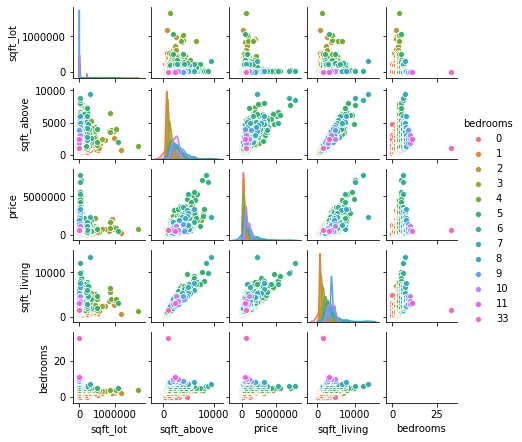

In [10]:
#faire pairplot en mettant en argument bedrooms afin de regarder l'impacte de cette variable  
plt.figure(figsize=(14,6))
sns.pairplot(df, hue="bedrooms", height=1.2, vars=["sqft_lot", "sqft_above", "price", "sqft_living", "bedrooms"]) 

In [0]:
#que remarquez vous ? 

On peut remarquer que cela forme une matrice symétrique, et au milieu dans la diagonale, cela montre la corrélation de chaque élément avec la variable bedrooms.

On peut voir l'évolution de chacun des éléments par rapport à la valeur de bedrooms.

In [11]:
#extraire les valeurs du prix (votre vecteur cible) dans une nouvelle variable et afficher sa taille 
price = df["price"]
print("taille du vecteur cible : ", price.size)

taille du vecteur cible :  21613


In [12]:
#supprimer la variable prix dans votre variable 
new_df = df.drop(["price"], axis=1)
new_df.shape
#pourquoi drop cette variable ?  

(21613, 16)

On drop la variable prix pour isoler le vecteur cible qui est le prix et lancer la régression.

In [0]:
#créer une votre variable de travail X 
#rappel : il faut que ce soit un objet numpy ! 

In [13]:
#enregistrer le nom de vos colonnes dans une list 
col = list(new_df.columns) 
col

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [0]:
from sklearn.linear_model import Lasso

In [15]:
#créer un 'Lasso estimator'
regLasso = Lasso(alpha=0.2, normalize=True)
print(regLasso)

Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score 

In [0]:
#fiter sur votre ensemble de donnée 
X = new_df.loc[:, col]
Y = []

for i in price:
    y = 0 
    y = np.mean(i, dtype=np.float64)
    Y.append(y)

Y = np.asarray(Y)

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [0]:
lasso = regLasso.fit(X_train, y_train)

In [19]:
#afficher les coefficients 
print(lasso.coef_)

[-4.48884085e+04  4.77575051e+04  2.12321080e+02  1.07680469e-01
  1.14446304e+04  2.68912026e+04  9.92412096e+04 -2.76158557e+01
 -3.56554468e+01 -2.91451317e+03  3.37016113e+01 -4.58299930e+02
  5.47169518e+05 -2.34779945e+05  3.95832627e+01 -2.57710444e-01]


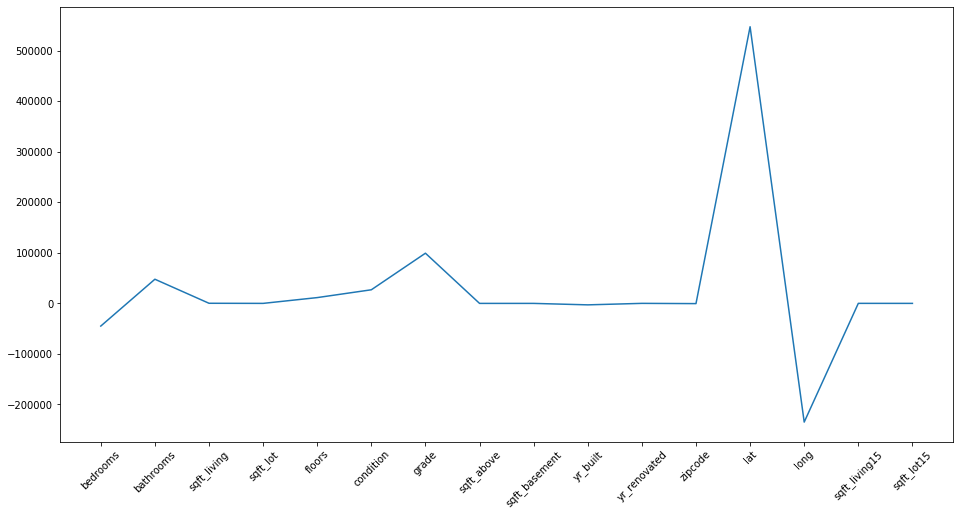

In [19]:
#ploter les coefficients avec les bon noms
#que remarquez vous ?

plt.figure(figsize=(16,8))
plt.xticks(rotation=45)
plt.plot(col, lasso.coef_)
plt.show()

On peut voir qu'il existe quelques variables dont les coefficients stagnent autour de 0 et d'autres dont les coefficients évoluent positiviement ou négativement.   

In [30]:
#essayer lasso avec un alpha = 100 et afficher les coefs
#que remarquez vous ? 
regLasso = Lasso(alpha=100, normalize=True)
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=100, random_state=42)
lasso = regLasso.fit(X_train, y_train)
lasso.coef_

array([-2.51205907e+03,  3.65309263e+03,  1.70761204e+02,  0.00000000e+00,
        0.00000000e+00,  9.99654404e+03,  1.02261868e+05,  0.00000000e+00,
        0.00000000e+00, -1.95105665e+03,  1.53659312e+01, -0.00000000e+00,
        4.71130700e+05, -7.68568643e+04,  2.23183215e+01, -0.00000000e+00])

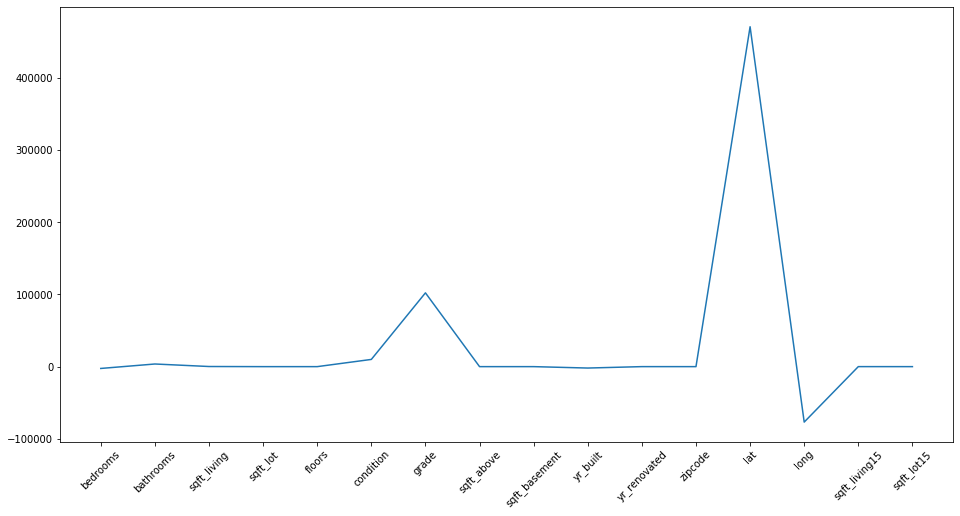

In [23]:
#afficher la courbe 
plt.figure(figsize=(16,8))
plt.xticks(rotation=45)
plt.plot(col, lasso.coef_)
plt.show()

On peut remarquer qu'il existe moins de variables dont les coefficients ne stagnent pas autour de 0.
Mais la forme su graphique est encore à peu près similaire. 

In [29]:
#pareil avec un alpha = 1000 et afficher les coefs
#que remarquez vous cette fois ci?

regLasso = Lasso(alpha=1000, normalize=True)
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=1000, random_state=42)
lasso = regLasso.fit(X_train, y_train)
lasso.coef_

array([    0.        ,     0.        ,    97.05730287,     0.        ,
           0.        ,     0.        , 28574.04041706,     0.        ,
           0.        ,    -0.        ,     0.        ,     0.        ,
           0.        ,    -0.        ,     0.        ,     0.        ])

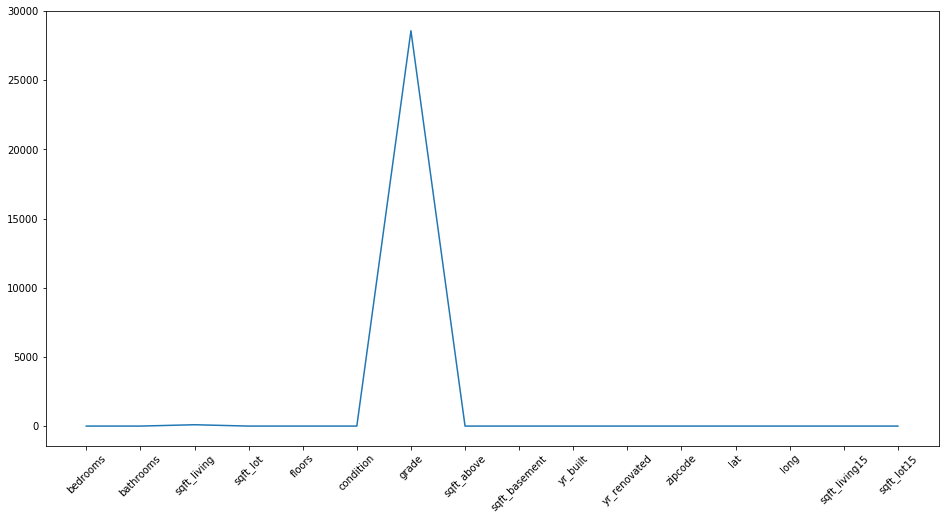

In [26]:
#afficher la courbe 
plt.figure(figsize=(16,8))
plt.xticks(rotation=45)
plt.plot(col, lasso.coef_)
plt.show()

On peut donc remarquer qu'en changeant de plus en plus fortement le alpha de notre objet Lasso, on a de moins en moins de variables.
Il y a de plus en plus de coefficients se trouvant autour de 0.

## La cross validation 
La validation croisée (ou cross-validation) est en apprentissage automatique, une méthode d’estimation de fiabilité d’un modèle fondé sur une technique d’échantillonnage. 

**Rechercher ce qu'est une cross-validation et faite appliquer la sur votre dataset, afficher votre score moyen pour 5 itérations**

In [0]:
from sklearn.model_selection import cross_validate

In [35]:
#afficher votre tableau de cross validation ainsi que la moyenne 
cv_results = cross_validate(lasso, X_train, y_train, cv=5)
print(cv_results['test_score'])
print("Average 5-Fold CV Score : ", cv_results['test_score'].mean())

[0.6365546  0.6238471  0.64489101 0.65522902 0.66023094]
Average 5-Fold CV Score :  0.6441505359205025


# Régressions Régularisées

La régularisation consiste à introduire une notion de pénalité dans notre manière de mesurer l'érreur (la somme des erreurs au carré pour nous) cela nous permet donc d'inférer sur nos paramètres. Il faut ajuster ce terme de régularisation dans le but d’obtenir un modèle de meilleure qualité. 

La régularisation de Tikhonov, plus connue sous le nom de **"ridge regression"** est une méthode qui consiste à ajouter une contrainte sur les coefficients lors de la modélisation pour maîtriser l’amplitude de leurs valeurs (« pour éviter qu’elles partent dans tous les sens »)

On va donc essayé d'appliquer Ridge sur nos données.

In [0]:
#définir un range de 50 valeur de 10-4 à 1 avec la fonction logspace  
#que fait la fonction logspace de numpy? 


array([1.00000000e-04, 1.20679264e-04, 1.45634848e-04, 1.75751062e-04,
       2.12095089e-04, 2.55954792e-04, 3.08884360e-04, 3.72759372e-04,
       4.49843267e-04, 5.42867544e-04, 6.55128557e-04, 7.90604321e-04,
       9.54095476e-04, 1.15139540e-03, 1.38949549e-03, 1.67683294e-03,
       2.02358965e-03, 2.44205309e-03, 2.94705170e-03, 3.55648031e-03,
       4.29193426e-03, 5.17947468e-03, 6.25055193e-03, 7.54312006e-03,
       9.10298178e-03, 1.09854114e-02, 1.32571137e-02, 1.59985872e-02,
       1.93069773e-02, 2.32995181e-02, 2.81176870e-02, 3.39322177e-02,
       4.09491506e-02, 4.94171336e-02, 5.96362332e-02, 7.19685673e-02,
       8.68511374e-02, 1.04811313e-01, 1.26485522e-01, 1.52641797e-01,
       1.84206997e-01, 2.22299648e-01, 2.68269580e-01, 3.23745754e-01,
       3.90693994e-01, 4.71486636e-01, 5.68986603e-01, 6.86648845e-01,
       8.28642773e-01, 1.00000000e+00])

In [0]:
#créer 2 tableaux pour stocker les résultat 
# un tableau pour le scrore moyen de la cross-validation (10 epoch)
# un tableau pour la variance moyenne 


In [0]:
#instancier un 'Ridge estimator' normalisé 
#A quoi sert la normalisation ? 


In [0]:
#faire une boucle sur les alpha 
# --> but : voir l'effet du paramètre alpha sur l'accuracy   
#
#        INDICE 
#
# pour chaque alpha faite 10 cross-validation 
# ajouter les résultats à vos tableaux 
#que remarquez vous ? 


scores moyens : 0.6516384157603821

variance moyenne : 0.01739819241056429


Utiliser la fonction ci-dessous, expliquer la et commenter le résultat : 
```python
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()


```

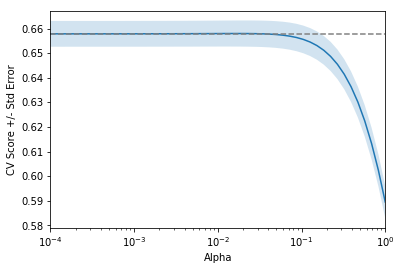

In [0]:
#que remarquez vous par rapport au coefficient alpha ? 
